In [2]:
import sys
import os
sys.path.append(os.path.abspath(r"C:\Users\utkarsh\OneDrive\Desktop\quant-projects\project1_option_vol\src"))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import ipywidgets as widgets
from IPython.display import display

from implied_vol import implied_volatility
from bs import black_scholes_price


In [3]:
ticker_dropdown = widgets.Dropdown(
    options=['AAPL', 'MSFT', 'TSLA', 'GOOG', 'AMZN'],
    value='AAPL',
    description='Ticker:'
)
display(ticker_dropdown)


Dropdown(description='Ticker:', options=('AAPL', 'MSFT', 'TSLA', 'GOOG', 'AMZN'), value='AAPL')

In [4]:
def fetch_option_chain(ticker):
    stock = yf.Ticker(ticker)
    expiries = stock.options
    if not expiries:
        raise ValueError(f"No options available for {ticker}")
    expiry = expiries[0]  # nearest expiry for now
    opt_chain = stock.option_chain(expiry)
    calls = opt_chain.calls
    puts = opt_chain.puts
    return expiry, calls, puts

expiry, calls, puts = fetch_option_chain(ticker_dropdown.value)
calls.head()


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,GOOG250905C00100000,2025-09-05 18:24:43+00:00,100.0,134.52,134.25,136.85,2.330002,1.762616,2,5,7.726563,True,REGULAR,USD
1,GOOG250905C00110000,2025-09-02 14:45:22+00:00,110.0,99.64,124.50,126.85,0.000000,0.000000,2,5,7.242188,True,REGULAR,USD
2,GOOG250905C00130000,2025-09-04 14:38:21+00:00,130.0,98.70,104.40,106.85,0.000000,0.000000,1,1,5.699222,True,REGULAR,USD
3,GOOG250905C00135000,2025-09-05 19:26:00+00:00,135.0,99.59,99.55,101.85,41.629997,71.825386,2,1,5.511722,True,REGULAR,USD
4,GOOG250905C00140000,2025-09-04 14:56:25+00:00,140.0,87.85,94.70,96.85,0.000000,0.000000,1,4,5.312503,True,REGULAR,USD


In [5]:
S0 = yf.Ticker(ticker_dropdown.value).history(period="1d")["Close"].iloc[-1]
r = 0.05   # risk-free rate assumption
T = 0.05   # placeholder, will compute from expiry

expiry_date = pd.to_datetime(expiry).date()
today = pd.Timestamp.today().date()
T = (expiry_date - today).days / 365.0

calls["implied_vol"] = calls.apply(
    lambda row: implied_volatility(
        market_price=row["lastPrice"],
        S=S0, K=row["strike"], T=T, r=r, option_type="call"
    ),
    axis=1
)

calls = calls.dropna(subset=["implied_vol"])
calls.head()


C:\Users\utkarsh\OneDrive\Desktop\quant-projects\project1_option_vol\src\bs.py:8: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\utkarsh\OneDrive\Desktop\quant-projects\project1_option_vol\src\bs.py:9: RuntimeWarning: invalid value encountered in sqrt
  d2 = d1 - sigma * np.sqrt(T)
C:\Users\utkarsh\OneDrive\Desktop\quant-projects\project1_option_vol\src\bs.py:28: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\utkarsh\OneDrive\Desktop\quant-projects\project1_option_vol\src\bs.py:29: RuntimeWarning: invalid value encountered in sqrt
  return S * norm.pdf(d1) * np.sqrt(T)


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,implied_vol


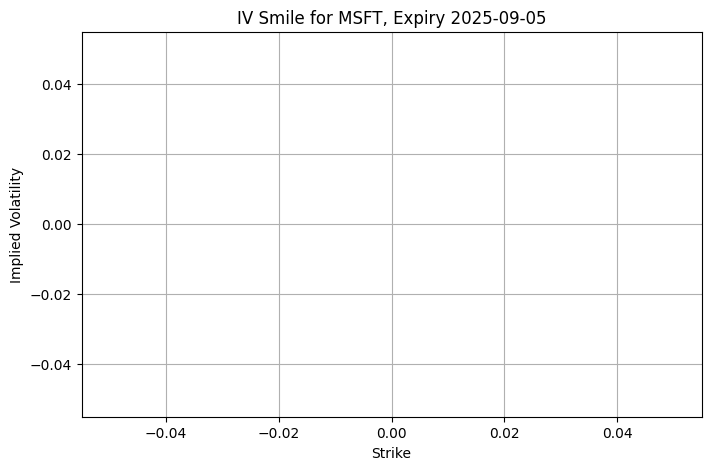

In [5]:
plt.figure(figsize=(8,5))
plt.plot(calls["strike"], calls["implied_vol"], marker="o")
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.title(f"IV Smile for {ticker_dropdown.value}, Expiry {expiry}")
plt.grid(True)
plt.show()


In [7]:
from mpl_toolkits.mplot3d import Axes3D

all_data = []
stock = yf.Ticker(ticker_dropdown.value)

for expiry in stock.options[:5]:  # first 5 expiries
    expiry_date = pd.to_datetime(expiry).date()
    T = (expiry_date - today).days / 365.0
    calls = stock.option_chain(expiry).calls
    calls["implied_vol"] = calls.apply(
        lambda row: implied_volatility(
            market_price=row["lastPrice"],
            S=S0, K=row["strike"], T=T, r=r, option_type="call"
        ),
        axis=1
    )
    calls = calls.dropna(subset=["implied_vol"])
    for _, row in calls.iterrows():
        all_data.append([row["strike"], T, row["implied_vol"]])

df_surface = pd.DataFrame(all_data, columns=["strike","maturity","iv"])


C:\Users\utkarsh\OneDrive\Desktop\quant-projects\project1_option_vol\src\bs.py:8: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\utkarsh\OneDrive\Desktop\quant-projects\project1_option_vol\src\bs.py:9: RuntimeWarning: invalid value encountered in sqrt
  d2 = d1 - sigma * np.sqrt(T)
C:\Users\utkarsh\OneDrive\Desktop\quant-projects\project1_option_vol\src\bs.py:28: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\utkarsh\OneDrive\Desktop\quant-projects\project1_option_vol\src\bs.py:29: RuntimeWarning: invalid value encountered in sqrt
  return S * norm.pdf(d1) * np.sqrt(T)
C:\Users\utkarsh\OneDrive\Desktop\quant-projects\project1_option_vol\src\bs.py:8: RuntimeWarning: overflow encountered in scalar power
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\utkarsh\OneDrive\Desktop\quant-projec

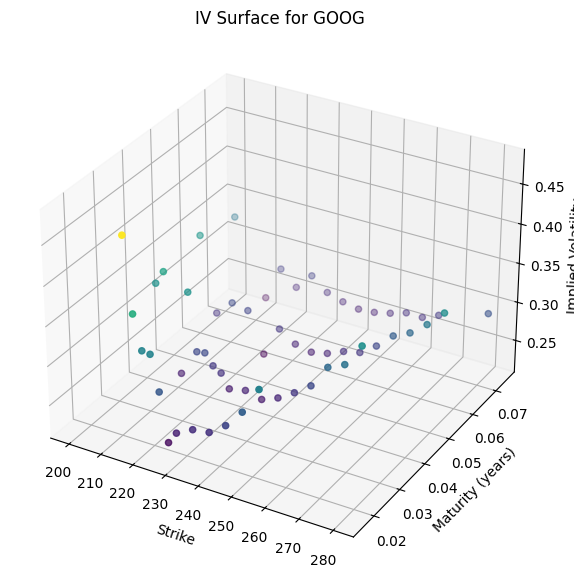

In [8]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_surface["strike"], df_surface["maturity"], df_surface["iv"], c=df_surface["iv"], cmap="viridis")
ax.set_xlabel("Strike")
ax.set_ylabel("Maturity (years)")
ax.set_zlabel("Implied Volatility")
ax.set_title(f"IV Surface for {ticker_dropdown.value}")
plt.show()
